In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd 

In [2]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,points,sigma):
        """ Generate a full Heap Map for every points in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
        """
        hm = np.zeros((height, width, len(points)), dtype = np.float32)
        for i in range(len(points)):
            hm[:,:,i] = gaussian_k(points[i][0],
                                    points[i][1],
                                    sigma, width, height)
        return hm
    
def get_y_as_heatmap(df,height,width, sigma):
    columns_lmxy = df.columns[1:]
    
    columns_lm = [] 
    for c in columns_lmxy:
        c = c[1:]
        if c not in columns_lm:
            columns_lm.extend([c])
    
    y_train = []
    for i in range(df.shape[0]):
        landmarks = []
        for colnm in columns_lm:
            x = df['x'+colnm].iloc[i] / 5.
            y = df['y'+colnm].iloc[i] / 5.
            if np.isnan(x) or np.isnan(y):
                x, y = -1, -1
            landmarks.append([x,y])
        y_train.append(generate_hm(height, width, landmarks, sigma))
    y_train = np.array(y_train)
    
    return(y_train,df[columns_lmxy],columns_lmxy)

In [3]:
def load(width=128,height=96,sigma=5):#96, 96
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    heatmaps:  2-d numpy array (Nsample, Nlandmarks*2) 
        In total there are 15 landmarks. 
        As x and y coordinates are recorded, u.shape = (Nsample,30)
    df_points: panda dataframe containins the landmarks
       
    """
    from sklearn.utils import shuffle
    
    path = "./data/keypoints.csv"
    df = pd.read_csv(os.path.expanduser(path)) 

    heatmaps, df_points, df_points_labels = get_y_as_heatmap(df,height,width, sigma)
#     heatmaps, df_points = shuffle(heatmaps, df_points, random_state=42)
    heatmaps = heatmaps.astype(np.float32)
    
    return heatmaps, df_points, df_points_labels

In [4]:
sigma = 3

heatmaps, df_points, df_points_labels = load(sigma=sigma)

Found 317 files belonging to 2 classes.


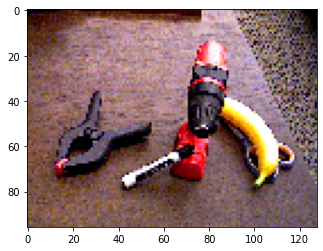

In [5]:
from pathlib import Path
root = Path().cwd()/"data"

images = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    image_size=(96, 128),
    shuffle=False
)

images, _ = zip(*images.unbatch())
images = np.array(images)
images.shape
images /= 255.
plt.imshow(images[0])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, heatmaps, test_size=0.2, random_state=42)

## Visualize image together with heatmap

C:\Users\MatiX\AppData\Local\Temp/ipykernel_17724/2412768200.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, keypoint_number/2, 1)
C:\Users\MatiX\AppData\Local\Temp/ipykernel_17724/2412768200.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, keypoint_number/2, j+2)


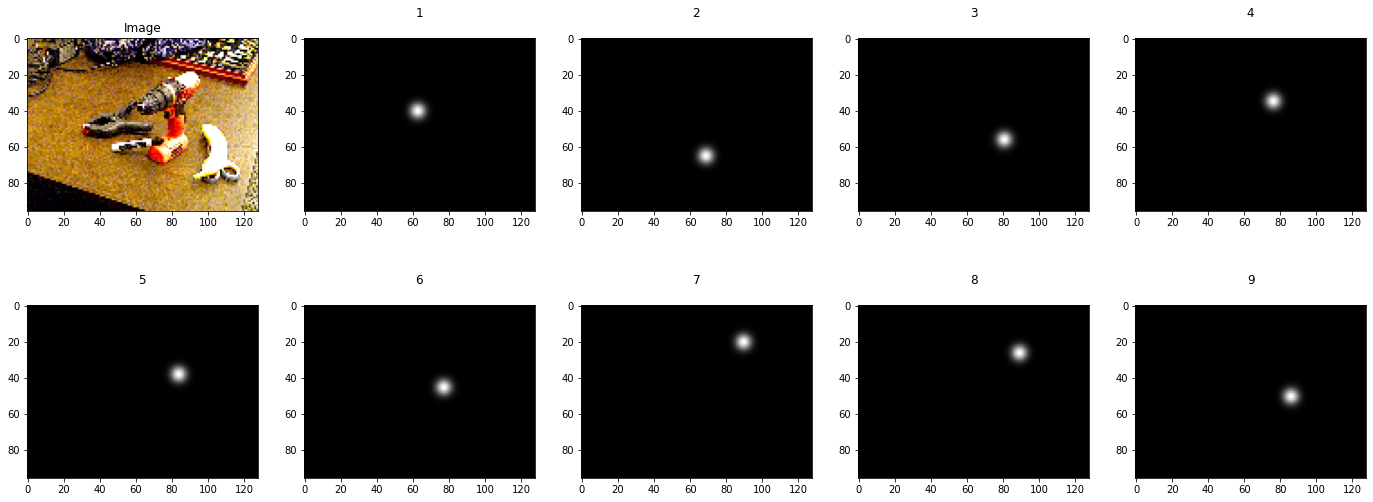

In [7]:
idx = 100

def plot_image_with_keypoints_heatmap(image, heatmap):
    keypoint_number = heatmap.shape[2]+1

    fig = plt.figure(figsize=(24,9))
    ax = fig.add_subplot(2, keypoint_number/2, 1)
    ax.imshow(image)
    ax.set_title("Image")
    for j, lab in enumerate(df_points_labels[::2]):
        ax = fig.add_subplot(2, keypoint_number/2, j+2)
        ax.imshow(heatmap[:,:,j],cmap="gray")
        ax.set_title(str(j + 1) +"\n" + lab[:-2] )
    plt.show()

plot_image_with_keypoints_heatmap(images[idx], heatmaps[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


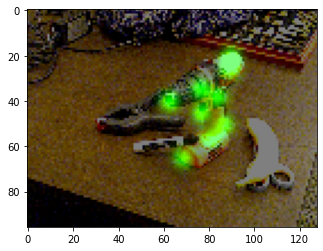

In [8]:
idx = 100

def plot_image_with_heatmaps(image, heatmap):
    image = image.copy()
    image *= 0.5

    for i in range(9):
        image[:, :, 1] = image[:, :, 1] + heatmap[:,:,i]

    plt.imshow(image)
    
plot_image_with_heatmaps(images[idx], heatmaps[idx])

# Model

In [9]:
from stacked_hourglass import create_stacked_hourglass_model

N_KEYPOINTS = 9
N_HOURGLASSES = 4
START_FILTERS = 32
MAX_FILTERS = 128

In [10]:
img_input = tf.keras.Input(shape=(96, 128, 3))
stacked_hourglass_model = create_stacked_hourglass_model(img_input, 
                                                         N_KEYPOINTS, 
                                                         N_HOURGLASSES, 
                                                         START_FILTERS, 
                                                         MAX_FILTERS, 
                                                         mode='simple')

# Training

In [11]:
stacked_hourglass_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                                loss=tf.keras.losses.mean_squared_error)
model_history = stacked_hourglass_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 8s 473ms/step - loss: 0.0503 - output_0_loss: 0.0065 - output_1_loss: 0.0073 - output_2_loss: 0.0139 - output_3_loss: 0.0226 - val_loss: 0.0111 - val_output_0_loss: 0.0023 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0027 - val_output_3_loss: 0.0027
Epoch 2/100
8/8 [==============================] - 2s 241ms/step - loss: 0.0101 - output_0_loss: 0.0023 - output_1_loss: 0.0028 - output_2_loss: 0.0025 - output_3_loss: 0.0026 - val_loss: 0.0094 - val_output_0_loss: 0.0022 - val_output_1_loss: 0.0024 - val_output_2_loss: 0.0023 - val_output_3_loss: 0.0024
Epoch 3/100
8/8 [==============================] - 2s 245ms/step - loss: 0.0093 - output_0_loss: 0.0022 - output_1_loss: 0.0024 - output_2_loss: 0.0023 - output_3_loss: 0.0024 - val_loss: 0.0092 - val_output_0_loss: 0.0022 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0023 - val_output_3_loss: 0.0023
Epoch 4/100
8/8 [==============================] - 2s 244ms/step - loss: 0.0091

Epoch 28/100
8/8 [==============================] - 2s 247ms/step - loss: 0.0072 - output_0_loss: 0.0021 - output_1_loss: 0.0017 - output_2_loss: 0.0017 - output_3_loss: 0.0017 - val_loss: 0.0073 - val_output_0_loss: 0.0021 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0017 - val_output_3_loss: 0.0017
Epoch 29/100
8/8 [==============================] - 2s 242ms/step - loss: 0.0072 - output_0_loss: 0.0021 - output_1_loss: 0.0017 - output_2_loss: 0.0017 - output_3_loss: 0.0017 - val_loss: 0.0072 - val_output_0_loss: 0.0021 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0017 - val_output_3_loss: 0.0017
Epoch 30/100
8/8 [==============================] - 2s 243ms/step - loss: 0.0071 - output_0_loss: 0.0021 - output_1_loss: 0.0017 - output_2_loss: 0.0017 - output_3_loss: 0.0016 - val_loss: 0.0071 - val_output_0_loss: 0.0021 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0017 - val_output_3_loss: 0.0016
Epoch 31/100
8/8 [==============================] - 2s 241ms/step - loss: 0.

8/8 [==============================] - 2s 244ms/step - loss: 0.0052 - output_0_loss: 0.0020 - output_1_loss: 0.0012 - output_2_loss: 0.0011 - output_3_loss: 8.8640e-04 - val_loss: 0.0052 - val_output_0_loss: 0.0020 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0011 - val_output_3_loss: 9.0867e-04
Epoch 55/100
8/8 [==============================] - 2s 244ms/step - loss: 0.0050 - output_0_loss: 0.0020 - output_1_loss: 0.0011 - output_2_loss: 0.0011 - output_3_loss: 8.3848e-04 - val_loss: 0.0051 - val_output_0_loss: 0.0020 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0011 - val_output_3_loss: 8.7242e-04
Epoch 56/100
8/8 [==============================] - 2s 243ms/step - loss: 0.0053 - output_0_loss: 0.0020 - output_1_loss: 0.0012 - output_2_loss: 0.0012 - output_3_loss: 9.6635e-04 - val_loss: 0.0055 - val_output_0_loss: 0.0020 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0012 - val_output_3_loss: 0.0010
Epoch 57/100
8/8 [==============================] - 2s 242ms/step - l

8/8 [==============================] - 2s 241ms/step - loss: 0.0034 - output_0_loss: 0.0018 - output_1_loss: 7.7983e-04 - output_2_loss: 4.8709e-04 - output_3_loss: 3.3806e-04 - val_loss: 0.0035 - val_output_0_loss: 0.0019 - val_output_1_loss: 8.2472e-04 - val_output_2_loss: 5.0053e-04 - val_output_3_loss: 3.4739e-04
Epoch 80/100
8/8 [==============================] - 2s 244ms/step - loss: 0.0034 - output_0_loss: 0.0018 - output_1_loss: 7.6860e-04 - output_2_loss: 4.6941e-04 - output_3_loss: 3.1410e-04 - val_loss: 0.0035 - val_output_0_loss: 0.0018 - val_output_1_loss: 8.1283e-04 - val_output_2_loss: 4.9752e-04 - val_output_3_loss: 3.4805e-04
Epoch 81/100
8/8 [==============================] - 2s 241ms/step - loss: 0.0033 - output_0_loss: 0.0018 - output_1_loss: 7.5163e-04 - output_2_loss: 4.5291e-04 - output_3_loss: 2.9947e-04 - val_loss: 0.0035 - val_output_0_loss: 0.0018 - val_output_1_loss: 8.0794e-04 - val_output_2_loss: 4.9260e-04 - val_output_3_loss: 3.4707e-04
Epoch 82/100
8/8 

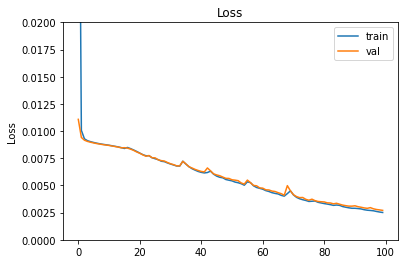

In [12]:
def plot_stats(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    ax = plt.gca()
    ax.set_ylim([0.0, 0.02])
    plt.legend(['train', 'val'])
    plt.show()
    
plot_stats(model_history)

# Evaluation

## Predicted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


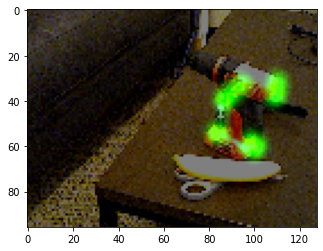

In [22]:
idx = 10

image = X_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1][0]

plot_image_with_heatmaps(image, pred_heatmaps)

## Ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


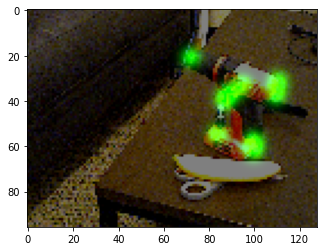

In [23]:
image = X_test[idx]
heatmaps = y_test[idx]

plot_image_with_heatmaps(image, heatmaps)